In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Méthode Galerkine point par point
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations des librairies

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv

import fonctions_projet_divergence as fpd #pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D
import matplotlib.patches as mpatches #pour le nageur


In [3]:
def plot_champ_vitesse(u,v,x,y,title):
    "Fonction de tracé du champ de vitesse"
    #norme
    f=2
    u1=np.copy(u)[::f,::f]
    v1=np.copy(v)[::f,::f]
    x1=np.copy(x)[::f,::f]
    y1=np.copy(y)[::f,::f]
    
    velocity=np.sqrt(u1**2+v1**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title, figsize=figsize)
    im=ax.quiver(x1,y1,u1/velocity,v1/velocity,colors,headwidth=8)
    cbar=plt.colorbar(im, ax=ax)  #pour la barre de couleur
    cbar.set_label(r'vitesse en $mm\cdot s^{-1}$',fontsize=fontsize)
    circle = mpatches.Circle((0,0), 6, color='gainsboro')#patch
    ax.add_patch(circle)
    
    fig.suptitle(title,fontsize=18)
    plt.xlabel(r"$x (mm)$",fontsize=fontsize)
    plt.ylabel(r"$y (mm)$",fontsize=fontsize)
    plt.show()
    
def plot_divergence(div,dx,dy,title):
    "Tracé des divergences"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=25).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title,figsize=figsize)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    l0.set_xlabel(r"$x (mm)$",fontsize=fontsize)
    l0.set_ylabel(r"$y (mm)$",fontsize=fontsize)
    circle = mpatches.Circle((0,0), 6, color='gainsboro')#patch
    l0.add_patch(circle)
    cbar=plt.colorbar(im0,ax=l0)
    cbar.set_label(r'$s^{-1}$',fontsize=fontsize)
   
    fig.suptitle(title,fontsize=20)
    plt.show()

# Chargement des données
## Choix des variables

In [4]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
m=5

## Constitution des tableaux
### Données brutes

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

piv=fpd.PIV(prof,manips)#données pour la profondeur

P=fpd.nb_plan(prof)#nombre de plan dans la profondeur choisie

u,v,x,y,z=fpd.donnees2(P,piv)
print(np.shape(u),np.shape(v),np.shape(x),np.shape(y),np.shape(z))

#tableau des z:
z=np.reshape(z,(P,1))
z_2D=np.hstack((z,z))
for i in range(57):
    z_2D=np.hstack((z_2D,z))
print(np.shape(z_2D))

z_3D=np.hstack((z_2D,z_2D))
for i in range(57):
    z_3D=np.hstack((z_3D,z_2D))
z_3D=np.reshape(z_3D,(P,59,59))
print(np.shape(z_3D))

(49, 60, 60) (49, 60, 60) (49, 60, 60) (49, 60, 60) (49,)
(49, 59)
(49, 59, 59)


### Divergence

In [6]:
div_2D=np.zeros((P,59,59))
dx=np.zeros((P,59,59))
dy=np.zeros((P,59,59))

for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],1)
    
print(np.shape(div_2D))

(49, 59, 59)


# Manque de données

In [7]:
print(np.size(u),np.shape(u))
nu=np.sum(u==0)
nv=np.sum(v==0)
ndiv=np.sum(div_2D==0)
print(nu,nv,ndiv)
print('{} % des valeurs sont égales à 0'.format(np.around(nu/np.size(u),decimals=1)))

176400 (49, 60, 60)
36706 36706 10638
0.2 % des valeurs sont égales à 0


In [19]:
v_nan=np.where(v==0,float('NaN'),v)
u_nan=np.where(u==0,float('NaN'),u)

div_2D_nan=np.zeros((P,59,59))

for plan in range(P):
    div_2D_nan[plan]=fpd.divergence2D_gauss(u_nan[plan],v_nan[plan],x[plan],y[plan],1)[0]

print(np.sum(np.isnan(div_2D_nan)),np.size(div_2D_nan))
div_2D_nan0=np.where(np.isnan(div_2D_nan),4,div_2D_nan)
#print(div_2D_nan0)

77970 170569


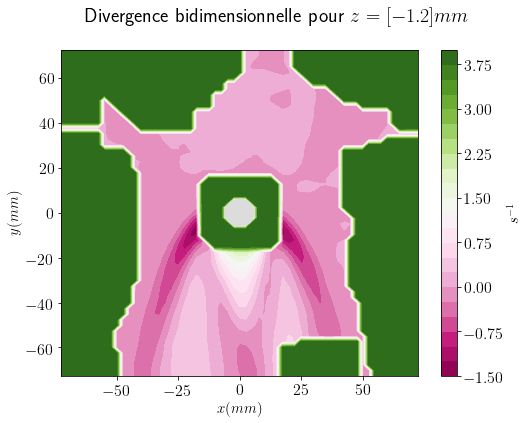

In [20]:
plan=2
fontsize=15
figsize=(8,6)
plot_divergence(div_2D_nan0[plan],dx[plan],dy[plan],r'Divergence bidimensionnelle pour $z = {} mm$'.format(np.around(-z[plan],decimals=1)))

In [10]:
print(np.shape(div_2D))
c=np.shape(div_2D)[1]
print(div_2D_nan[:6,0,0])
print(np.sum(np.isnan(div_2D_nan[:6,0,0])))

(49, 59, 59)
[       nan        nan        nan        nan        nan 0.01602563]
5


In [11]:
count=0
for i in range(c):
    for j in range(c):
        if np.sum(np.isnan(div_2D_nan[:,j,i]))>20:
            count+=1

In [12]:
print(count/(c*c))

0.5357655846021259


In [13]:
count=0
for i in range(c):
    for j in range(c):
        if np.sum(np.isnan(v_nan[:,j,i]))>20:
            count+=1

In [14]:
print(count/(c*c))

0.1373168629704108


In [15]:
count=0
for i in range(c):
    for j in range(c):
        if np.sum(div_2D[:,j,i]==0)>10:
            count+=1

In [16]:
print(count/(c*c))

0.06434932490663603


# Moyennage

In [ ]:
Mean_V = np.zeros([len(x_bins), len(y_bins)])

for i, x_bin in enumerate(x_bins[:-1]):
    bin_x = (x > x_bins[i]) & (x <= x_bins[i+1])
    for j, y_bin in enumerate(y_bins[:-1]):
        bin_xy = (y[bin_x] > y_bins[j]) & (y[bin_x] <= y_bins[j+1])
        if (sum(x > 0 for x in bin_xy) > 0) :
            Mean_V[i,j]=np.nanmean(V[bin_x][bin_xy])
        else:
            Mean_V[i,j]=np.nan

# Galerkine 1D

In [17]:





def methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine1D"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],2)
    #Matrice pinv
    pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)])))
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    return(vz)



In [18]:
def deriv(y,x,axis):
    """Dérive un tableau 2D y par rapport à x suivant un axe donné"""
    if axis==0:
        return((y[1:,:]-y[:-1,:])/(x[1:,:]-x[:-1,:]))#Donc là le tableau est de taille (n-1,n)
    if axis==1:
        return((y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1]))#Donc là le tableau est de taille (n,n-1)
    return("deriv ne fonctionne que pour des tableaux 2D")

def divergence2D_gauss(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien sur la vitesse"

    #Filtrage
    u_filtre=gaussian_filter(u,sigma)
    v_filtre=gaussian_filter(v,sigma)
    #dérivation
    du_filtre,dv_filtre=deriv(u_filtre,x,1),deriv(v_filtre,y,0)
    dx,dy=abcisse(x,1),abcisse(y,0)
    #shape
    du_filtre,dv_filtre=good_shape(du_filtre),good_shape(dv_filtre)
    dx,dy=good_shape(dx),good_shape(dy)
    #somme
    div = somme(du_filtre,dv_filtre)
    #masque
    div_masque=masque(div)
    return(div_masque,dx,dy)

def methode_Galerkine(u,v,x,y,z,P,m,h):
    "Applique la méthode Galerkine"
    #divergence bidimensionelle
    div_2D=np.zeros((P,59,59))
    dx=np.zeros((P,59,59))
    dy=np.zeros((P,59,59))
    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=fpd.divergence2D_gauss(u[plan],v[plan],x[plan],y[plan],2)
    #Matrice pinv
    pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*z) for n in range(1,m+1)])))
    #Calcul des coefficients
    div_2D=np.reshape(div_2D,(P,59*59))
    a=np.matmul(pinv,div_2D)
    #calcul de vz
    sin=np.transpose(np.array([np.sin(m*np.pi*z/h) for m in range(1,m+1)]))
    vz=np.matmul(sin,a)
    vz=np.reshape(vz,(P,59,59))
    return(vz)